In [84]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy import hstack
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot as plt

In [85]:
# https://stackoverflow.com/a/66174336/10945691
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [86]:
# https://github.com/tensorflow/tensorflow/issues/46038
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)

In [87]:
# TODO add parametrization for the conv2dt layers
def get_generator(input_size, ds_shape, kernel_initializer):
    input_latent = layers.Input(shape=(input_size))
    res = ds_shape[0] // 4
    depth = ds_shape[-1]

    n_nodes = 128 * res * res

    g = layers.Dense(n_nodes)(input_latent)
    g = layers.ReLU()(g)
    g = layers.BatchNormalization()(g)
    g = layers.Reshape((res, res, 128))(g)

    g = layers.Conv2D(64, 4, padding='same',activation='relu',kernel_initializer=kernel_initializer)(g)
    g = layers.ReLU()(g)
    g = layers.BatchNormalization()(g)

    g = layers.Conv2DTranspose(32, 4, strides=(2,2), padding='same',kernel_initializer=kernel_initializer)(g)
    g = layers.ReLU()(g)
    g = layers.BatchNormalization()(g)

    g = layers.Conv2DTranspose(depth, 4, strides=(2,2), padding='same',kernel_initializer=kernel_initializer)(g)
    output_layer = layers.Activation('sigmoid')(g)

    gen_model = Model(input_latent, output_layer)
    return gen_model

In [88]:
# TODO add parametrization for the conv2d layers
def get_discriminators(input_shape, kernel_initializer, qcodes, lr):
    input_image=layers.Input(shape=input_shape)

    l=layers.Conv2D(32, 4, strides=(2,2),padding='same', kernel_initializer=kernel_initializer)(input_image)
    l=layers.ReLU()(l)

    l=layers.Conv2D(64, 4, strides=(2,2), padding='same', kernel_initializer=kernel_initializer)(l)
    l=layers.ReLU()(l)
    l=layers.BatchNormalization()(l)

    l=layers.Conv2D(128, 4, strides=(2,2), padding='same', kernel_initializer=kernel_initializer)(l)
    l=layers.ReLU()(l)
    l=layers.BatchNormalization()(l)

    l=layers.Flatten()(l)
    
    out=layers.Dense(1, activation='sigmoid')(l)
    discriminator_model = Model(input_image, out)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr, beta_1=0.5))
    # create q model layers
    q = layers.Dense(128)(l)
    q = layers.BatchNormalization()(q)
    q = layers.LeakyReLU(alpha=0.1)(q)
    # q model output
    q_models = []
    for qdim, qtype in qcodes:
        out_codes = layers.Dense(
            qdim,
            activation='softmax' if qtype == 'onehot' else 'tanh' if qtype == 'continuous' else 'potato'
        )(q)
        q_models += [Model(input_image, out_codes)]
    return discriminator_model, q_models

In [89]:
def get_infogan(G, D, Qs, Qtypes, lr):
    for layer in D.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
    # connect g outputs to d inputs
    discr_output = D(G.output)
    # connect g outputs to q inputs
    q_outputs = [q(G.output) for q in Qs]
    # define composite model
    infogan_model = Model(G.input, [discr_output, *q_outputs])
    # compile model
    opt = Adam(lr=lr, beta_1=0.5)
    Qlosses = ['categorical_crossentropy' if qtype == 'onehot' else 'mse' for qtype in Qtypes]
    infogan_model.compile(loss=['binary_crossentropy', *Qlosses], optimizer=opt)
    return infogan_model

In [100]:
def generate_noise_and_codes(n_samples, zdim, qcodes):
    z = np.random.randn(n_samples, zdim)
    cat_codes = []
    for qdim, qtype in qcodes:
        if qtype == 'onehot':
            cat_codes += [np.eye(qdim)[np.random.choice(qdim, n_samples)]]
        elif qtype == 'continuous':
            cat_codes += [np.random.uniform(low = -1, high = 1, size = (n_samples, qdim))]
        else:
            raise 1
        z = hstack((z, cat_codes[-1]))
    return z, cat_codes

In [91]:
def generate_fake_samples(G, n_samples, zdim, qcodes):
    z, _ = generate_noise_and_codes(n_samples, zdim, qcodes)
    x = G.predict(z)
    y = zeros((n_samples, 1))
    return x, y

In [104]:
def generate_latent_points_from_cat(latent_dim, codes):
    z_latent = randn(len(codes), latent_dim)
    z_input = hstack((z_latent, codes))
    return z_input

def generate_fake_samples_and_z_from_cat(generator, latent_dim, codes):
    z_input = generate_latent_points_from_cat(latent_dim, codes)
    images = generator.predict(z_input)
    return images

def plotSome(gen, latent_dim, codes, grayscale = False):
    images = generate_fake_samples_and_z_from_cat(gen, latent_dim, codes)
    plt.subplots(figsize=(24, 24))
    for i in range(len(codes)):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.title(np.argmax(codes[i]))
        if grayscale:
            plt.imshow(images[i, :, :, 0], cmap='gray_r')
        else:
            plt.imshow(images[i], interpolation='nearest')
    plt.show()

In [93]:
class InfoGAN:
    def __init__(
        self,
        dsname = 'mnist',
        qcodes = [(10, 'onehot')],
        latent_dim = 100,
        batch_size = 32,
        stddev = 0.02,
        lr = 1e-4
    ):
        self.batch_size     = batch_size
        ds                  = self.load(dsname)
        self.ds             = ds[0]
        self.ds_info        = ds[1]
        self.ds_shape       = ds[2]
        self.qcodes         = qcodes
        self.latent_dim     = latent_dim
        self.gen_input_size = self.latent_dim + sum([dim for dim, datatype in self.qcodes])
        self.kernel_init    = RandomNormal(stddev=0.02)
        self.lr             = lr
        self.gen            = get_generator(self.gen_input_size, self.ds_shape, self.kernel_init)
        self.disc, self.qs  = get_discriminators(self.ds_shape, self.kernel_init, self.qcodes, self.lr)
        self.model          = get_infogan(
            self.gen,
            self.disc,
            self.qs,
            [qtype for qdim, qtype in self.qcodes],
            self.lr
        )

    def normalize_img(self, image, _):
        return tf.cast(image, tf.float32) / 255, 1

    def load(self, dsname):
        ds, ds_info = tfds.load(dsname, split='train', with_info=True,as_supervised=True)
        shape = ds_info.features['image'].shape
        ds = ds.map(self.normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.cache()
        # For true randomness, we set the shuffle buffer to the full dataset size.
        ds = ds.shuffle(ds_info.splits['train'].num_examples)
        # Batch after shuffling to get unique batches at each epoch.
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
        return ds,ds_info, shape

    # train the generator and discriminator
    def train(self, n_epochs=100, steps_per_epoch = None):
        # calculate the number of batches per training epoch
        if steps_per_epoch is None:
            steps_per_epoch = len(self.ds)
        # calculate the number of training iterations
        n_steps = steps_per_epoch * n_epochs
        # manually enumerate epochs
        for e in range(n_epochs):
            for i in range(steps_per_epoch):
                self.disc.fit(self.ds, steps_per_epoch=1, verbose = 0)
                X_fake, y_fake = generate_fake_samples(self.gen, self.batch_size, self.latent_dim, self.qcodes)
                self.disc.fit(X_fake, y_fake, verbose = 0)
                # d_loss2 = self.disc.train_on_batch(X_fake, y_fake)
                y_gan = ones((self.batch_size, 1))
                z_input, cat_codes = generate_noise_and_codes(self.batch_size, self.latent_dim, self.qcodes)
                self.model.fit(z_input, [y_gan, *cat_codes], verbose = 0)
                # _, *gan_losses = self.model.train_on_batch(z_input, [y_gan, *cat_codes])
                print('\r%d: %d/%d ' % (e + 1, i+1, steps_per_epoch), end = '')
                # print('\r%d: %d/%d, d: %.6f & %.6f, g: %.6f q: %.6f ' % (e + 1, i+1, bat_per_epo, d_loss1, d_loss2, *gan_losses), end = '')
            print()

In [11]:
infogan = InfoGAN(
    batch_size = 32,
    lr=2e-4,
    qcodes = [
        (10, 'onehot'),
        (1, 'continuous'),
        (1, 'continuous'),
    ],
)

In [12]:
infogan.train(n_epochs=100)

1: 1875/1875 
2: 1875/1875 
3: 1875/1875 
4: 1875/1875 
5: 1875/1875 
6: 1875/1875 
7: 1875/1875 
8: 1875/1875 
9: 1875/1875 
10: 1875/1875 


In [ ]:
# c1 = to_categorical([i % 10 for i in range(100)], 10)
# c2 = to_categorical([i % 10 for i in range(100)], 10)
# c3 = to_categorical([i % 10 for i in range(100)], 10)
# c4 = to_categorical([i % 10 for i in range(100)], 10)
# c5 = np.random.uniform(low = -1, high = 1, size = (100, 1))
# c6 = np.random.uniform(low = -1, high = 1, size = (100, 1))
# c = np.hstack((c1, c2))
# c = np.hstack((c, c3))
# c = np.hstack((c, c4))
# c = np.hstack((c, c5))
# c = np.hstack((c, c6))
# plotSome(infogan.gen, infogan.latent_dim, c)

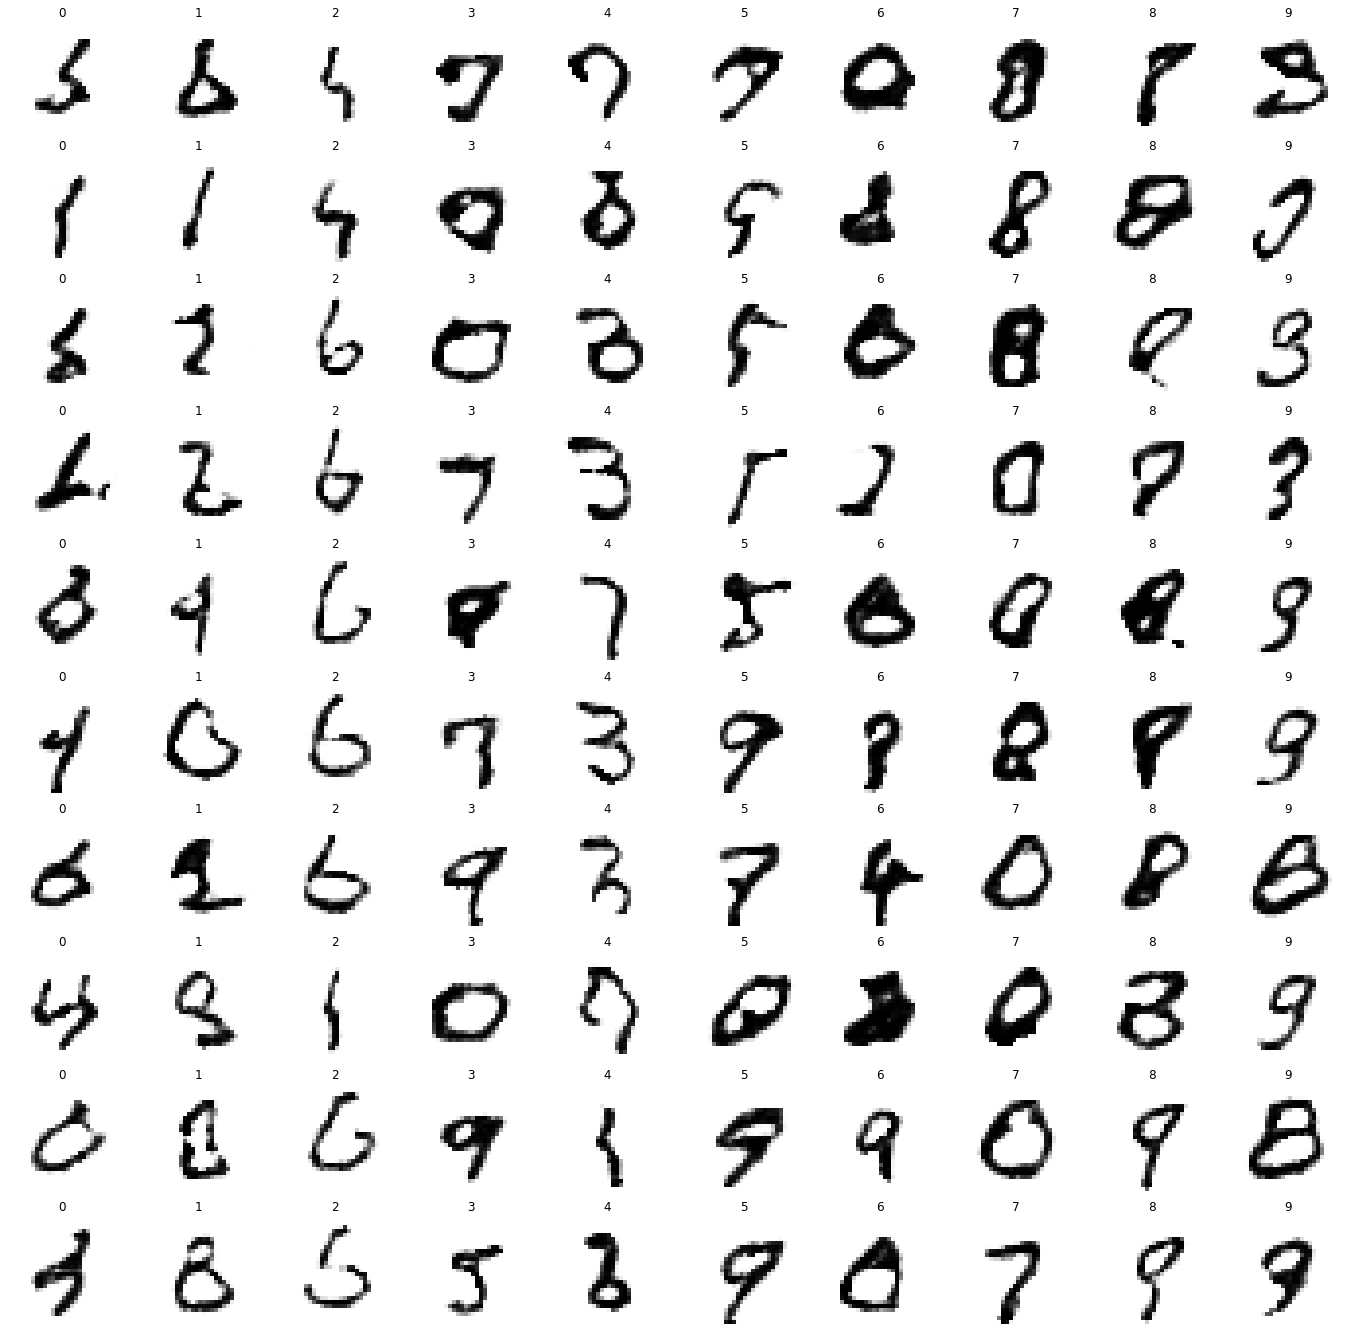

In [13]:
# c1 = to_categorical([i % 10 for i in range(100)], 10)
# plotSome(infogan.gen, infogan.latent_dim, c1, True)

In [98]:
# infogan = InfoGAN(
#     dsname = 'svhn_cropped',
#     batch_size = 32,
#     qcodes = [
#         (10, 'onehot'),
#         (10, 'onehot'),
#         (10, 'onehot'),
#         (10, 'onehot'),
#         (1, 'continuous'),
#         (1, 'continuous'),
#     ],
# )

In [ ]:
# infogan.train(n_epochs=10)

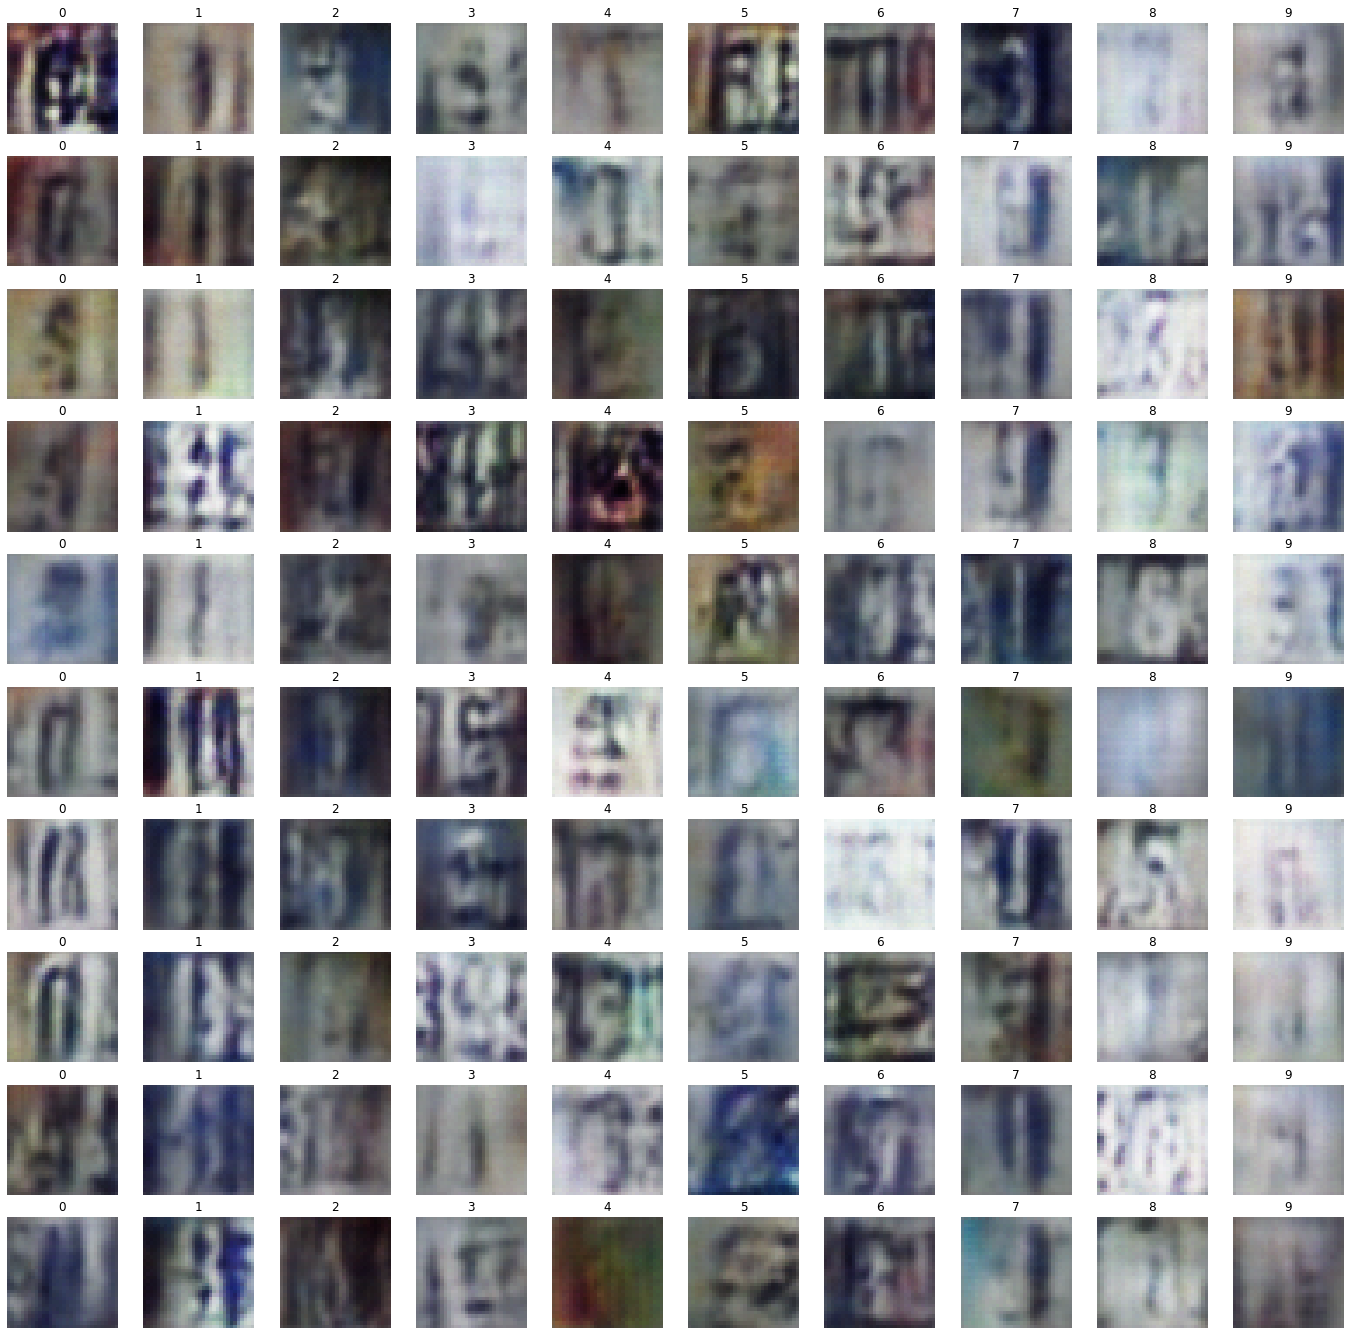

In [105]:
# c1 = to_categorical([i % 10 for i in range(100)], 10)
# c2 = to_categorical([i % 10 for i in range(100)], 10)
# c3 = to_categorical([i % 10 for i in range(100)], 10)
# c4 = to_categorical([i % 10 for i in range(100)], 10)
# c5 = np.random.uniform(low = -1, high = 1, size = (100, 1))
# c6 = np.random.uniform(low = -1, high = 1, size = (100, 1))
# c = np.hstack((c1, c2))
# c = np.hstack((c, c3))
# c = np.hstack((c, c4))
# c = np.hstack((c, c5))
# c = np.hstack((c, c6))
# plotSome(infogan.gen, infogan.latent_dim, c)